In [1]:
%load_ext autoreload
%autoreload 2
%cd "~/deepshape/deepshape"

/home/jorgen/deepshape/deepshape


In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from curves import *
from layers import *
from palais_layer import * 
from visual import *
from networks import ReparametrizationNetwork1D, train

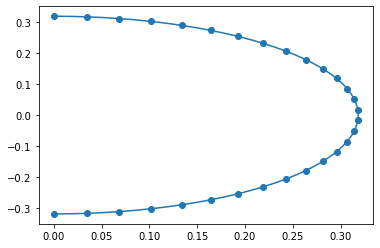

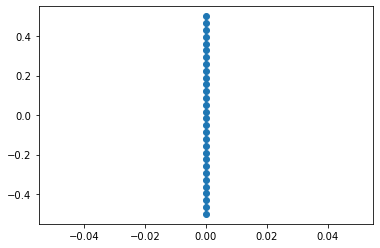

In [4]:
# Figures folder

# Instantiate curves and transforms (from curves library)
g = LogStepDiff
c1 = Circle
c2 = c1.compose(g)

# Take Qmaps
q, r = Qmap(c2), Qmap(c1)
c1 = Curve((
    lambda x: torch.sin(np.pi * x) / np.pi, 
    lambda x: torch.cos(np.pi * (x+1.)) / np.pi
))
c2 = Curve((lambda x: torch.zeros_like(x), lambda x: x - 0.5))
g = Diffeomorphism(lambda x: x - torch.sin(2*np.pi*x) / (2 * np.pi))


q = SRVT(c1)
r = SRVT(c2)



plot_curve(c1, dotpoints=30)
plot_curve(c2, dotpoints=30)

In [5]:
Z, Y = RN(x)
Q = q(x)
R = RN.reparametrized(r, x)

# Compute loss, and perform a backward pass and gradient step
l = loss(R, Q)

NameError: name 'RN' is not defined

In [7]:
RN = ReparametrizationNetwork1D(10, 10, layer_type=PalaisLayer1D)
# optimizer = optim.LBFGS(RN.parameters(), lr=1e-2)
optimizer = optim.Adam(RN.parameters(), lr=1e-3)
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.1)
log_every=10

tic = time.time()

# Initialize node placement
npoints = 256
x = torch.linspace(0, 1, npoints).unsqueeze(-1)
loss = nn.MSELoss()

maxiter=30
for i in range(maxiter):
    
    def closure():
        # Set gradient buffers to zero.
        optimizer.zero_grad()

        # Find current reparametrized Q-maps
        Z, Y = RN(x)
        Q = q(x)
        R = RN.reparametrized(r, x)

        # Compute loss, and perform a backward pass and gradient step
        l = loss(R, Q)
        l.backward()
        return l
    
    optimizer.step(closure)
    
    # Projection step
    with torch.no_grad():
        for layer in RN.layers:
            layer.project(npoints, epsilon=1e-2)
            
    # Find current reparametrized Q-maps
    Z, Y = RN(x)
    Q = q(x)
    R = RN.reparametrized(r, x)

    # Compute loss, and perform a backward pass and gradient step
    l = loss(R, Q)
    
    if log_every > 0 and i % log_every == 0:
        print('[Iter %5d] loss: %.6f' % (i + 1, l))

toc = time.time()
print()
print(f'Finished training in {toc - tic:.6f}s')

[Iter     1] loss: 0.361451
[Iter    11] loss: 0.324920
[Iter    21] loss: 0.304792

Finished training in 0.296386s


In [9]:
RN = ReparametrizationNetwork1D(10, 10)
optimizer = optim.LBFGS(RN.parameters(), lr=1e-2)
# optimizer = optim.Adam(RN.parameters(), lr=1e-3)
# optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.1)
log_every=10

tic = time.time()

# Initialize node placement
npoints = 256
x = torch.linspace(0, 1, npoints).unsqueeze(-1)
loss = nn.MSELoss()

maxiter=30
for i in range(maxiter):
    
    def closure():
        # Set gradient buffers to zero.
        optimizer.zero_grad()

        # Find current reparametrized Q-maps
        Z, Y = RN(x)
        Q = q(x)
        R = RN.reparametrized(r, x)

        # Compute loss, and perform a backward pass and gradient step
        l = loss(R, Q)
        l.backward()
        return l
    
    optimizer.step(closure)
    
    # Projection step
    with torch.no_grad():
        for layer in RN.layers:
            layer.project(npoints, epsilon=1e-2)
            
    # Find current reparametrized Q-maps
    Z, Y = RN(x)
    Q = q(x)
    R = RN.reparametrized(r, x)

    # Compute loss, and perform a backward pass and gradient step
    l = loss(R, Q)
    
    if log_every > 0 and i % log_every == 0:
        print('[Iter %5d] loss: %.6f' % (i + 1, l))

toc = time.time()
print()
print(f'Finished training in {toc - tic:.6f}s')

[Iter     1] loss: 0.316602
[Iter    11] loss: 0.293945
[Iter    21] loss: 0.293896

Finished training in 3.404347s


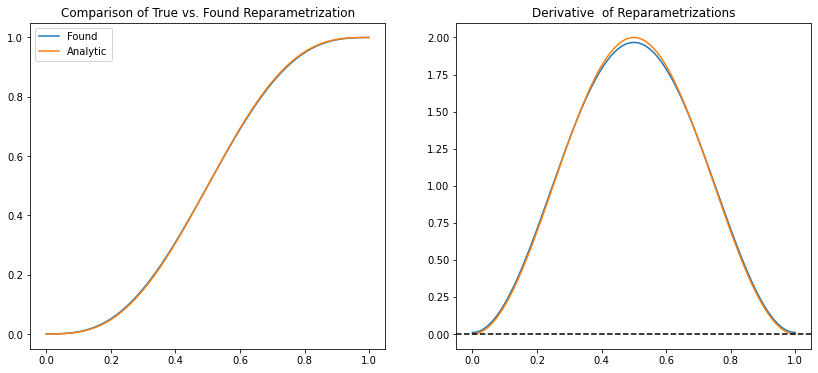

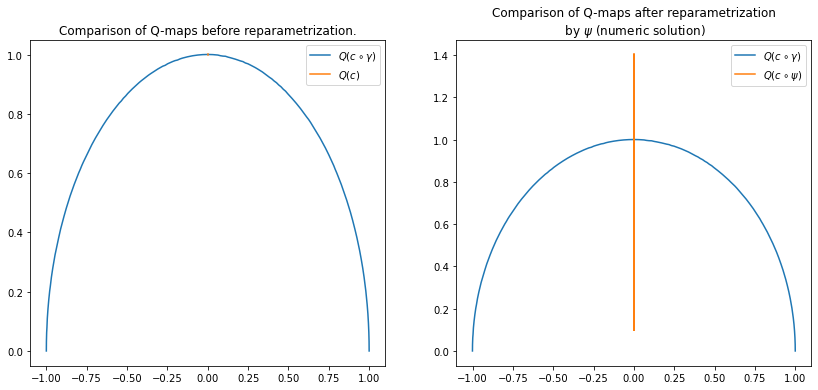

In [41]:
# Create Plotting Data to verify reparametrizations
x = torch.linspace(0, 1, 201).unsqueeze(-1)
z, y = RN(x)
z, y = z.detach(), y.detach()
Q, R = q(x), RN.reparametrized(r, x)
R = R.detach()

# Plot Diffeomorphism...
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x, z, label="Found")
plt.plot(x, g(x), label="Analytic")
plt.title("Comparison of True vs. Found Reparametrization")
plt.legend()

# ... and derivative to check if strictly positive
plt.subplot(1, 2, 2)
plt.plot(x, y, label="Found")
plt.plot(x, g.derivative(x), label="Analytic")
plt.axhline(0, ls='--', c='k')
plt.title("Derivative  of Reparametrizations")
plt.show()


# Plot Q-maps, and compare 
plt.figure(figsize=(14, 6))

# Before 
plt.subplot(1, 2, 1)
plt.plot(q(x)[:, 0], q(x)[:, 1], label="$Q(c \circ \gamma)$")
plt.plot(r(x)[:, 0], r(x)[:, 1], label="$Q(c)$")
plt.title("Comparison of Q-maps before reparametrization.")
plt.legend()

# .. and after reparametrization
plt.subplot(1, 2, 2)
plt.plot(Q[:, 0], Q[:, 1], label="$Q(c \circ \gamma)$")
plt.plot(R[:, 0], R[:, 1], label="$Q(c \circ \psi)$")
plt.title("Comparison of Q-maps after reparametrization\n by $\psi$ (numeric solution)")
plt.legend()

plt.show()

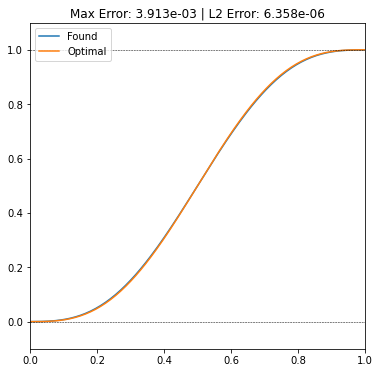

In [47]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(x, z, label="Found")
plt.plot(x, g(x), label="Optimal")
plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim(-0.1, 1.1)
plt.axhline(0, ls="--", lw=0.5, c="k")
plt.axhline(1, ls="--", lw=0.5, c="k")
plt.title(f"Max Error: {torch.abs(z - g(x)).max():.3e} | L2 Error: {nn.MSELoss()(z, g(x)):.3e}")
plt.show()